# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
import gc
gc.collect()

C:\Users\Sanjay\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


0

In [3]:
# # using SQLite Table to read data.
# con = sqlite3.connect('database.sqlite') 

# # filtering only positive and negative reviews i.e. 
# # not taking into consideration those reviews with Score=3
# # SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# # you can change the number to any other number based on your computing power

# # filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# # for tsne assignment you can take 5k data points

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# # Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
# def partition(x):
#     if x < 3:
#         return 0
#     return 1

# #changing reviews with score less than 3 to be positive and vice-versa
# actualScore = filtered_data['Score']
# positiveNegative = actualScore.map(partition) 
# filtered_data['Score'] = positiveNegative
# print("Number of data points in our data", filtered_data.shape)
# filtered_data.head(3)

In [3]:
# display = pd.read_sql_query("""
# SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
# FROM Reviews
# GROUP BY UserId
# HAVING COUNT(*)>1
# """, con)

In [4]:
# print(display.shape)
# display.head()

In [5]:
# display[display['UserId']=='AZY10LLTJ71NX']

In [6]:
# display['COUNT(*)'].sum()

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
# display= pd.read_sql_query("""
# SELECT *
# FROM Reviews
# WHERE Score != 3 AND UserId="AR5J8UI46CURR"
# ORDER BY ProductID
# """, con)
# display.head()

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
# #Sorting data according to ProductId in ascending order
# sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [8]:
# #Deduplication of entries
# final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
# final.shape

In [9]:
# #Checking to see how much % of data still remains
# (final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [10]:
# display= pd.read_sql_query("""
# SELECT *
# FROM Reviews
# WHERE Score != 3 AND Id=44737 OR Id=64422
# ORDER BY ProductID
# """, con)

# display.head()

In [11]:
# final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [12]:
# #Before starting the next phase of preprocessing lets see the number of entries left
# print(final.shape)

# #How many positive and negative reviews are present in our dataset?
# final['Score'].value_counts()

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [13]:
# # printing some random reviews
# sent_0 = final['Text'].values[0]
# print(sent_0)
# print("="*50)

# sent_1000 = final['Text'].values[1000]
# print(sent_1000)
# print("="*50)

# sent_1500 = final['Text'].values[1500]
# print(sent_1500)
# print("="*50)

# sent_4900 = final['Text'].values[4900]
# print(sent_4900)
# print("="*50)

In [14]:
# # remove urls from text python: https://stackoverflow.com/a/40823105/4084039
# sent_0 = re.sub(r"http\S+", "", sent_0)
# sent_1000 = re.sub(r"http\S+", "", sent_1000)
# sent_150 = re.sub(r"http\S+", "", sent_1500)
# sent_4900 = re.sub(r"http\S+", "", sent_4900)

# print(sent_0)

In [15]:
# # https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
# from bs4 import BeautifulSoup

# soup = BeautifulSoup(sent_0, 'lxml')
# text = soup.get_text()
# print(text)
# print("="*50)

# soup = BeautifulSoup(sent_1000, 'lxml')
# text = soup.get_text()
# print(text)
# print("="*50)

# soup = BeautifulSoup(sent_1500, 'lxml')
# text = soup.get_text()
# print(text)
# print("="*50)

# soup = BeautifulSoup(sent_4900, 'lxml')
# text = soup.get_text()
# print(text)

In [16]:
# # https://stackoverflow.com/a/47091490/4084039
# import re

# def decontracted(phrase):
#     # specific
#     phrase = re.sub(r"won't", "will not", phrase)
#     phrase = re.sub(r"can\'t", "can not", phrase)

#     # general
#     phrase = re.sub(r"n\'t", " not", phrase)
#     phrase = re.sub(r"\'re", " are", phrase)
#     phrase = re.sub(r"\'s", " is", phrase)
#     phrase = re.sub(r"\'d", " would", phrase)
#     phrase = re.sub(r"\'ll", " will", phrase)
#     phrase = re.sub(r"\'t", " not", phrase)
#     phrase = re.sub(r"\'ve", " have", phrase)
#     phrase = re.sub(r"\'m", " am", phrase)
#     return phrase

In [17]:
# sent_1500 = decontracted(sent_1500)
# print(sent_1500)
# print("="*50)

In [18]:
# #remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
# sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
# print(sent_0)

In [19]:
# #remove spacial character: https://stackoverflow.com/a/5843547/4084039
# sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
# print(sent_1500)

In [20]:
# # https://gist.github.com/sebleier/554280
# # we are removing the words from the stop words list: 'no', 'nor', 'not'
# # <br /><br /> ==> after the above steps, we are getting "br br"
# # we are including them into stop words list
# # instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

# stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
#             "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
#             'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
#             'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
#             'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
#             'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
#             'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
#             'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
#             'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
#             'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
#             's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
#             've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
#             "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
#             "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
#             'won', "won't", 'wouldn', "wouldn't"])

In [21]:
# # Combining all the above stundents 
# from tqdm import tqdm
# preprocessed_reviews = []
# # tqdm is for printing the status bar
# for sentance in tqdm(final['Text'].values):
#     sentance = re.sub(r"http\S+", "", sentance)
#     sentance = BeautifulSoup(sentance, 'lxml').get_text()
#     sentance = decontracted(sentance)
#     sentance = re.sub("\S*\d\S*", "", sentance).strip()
#     sentance = re.sub('[^A-Za-z]+', ' ', sentance)
#     # https://gist.github.com/sebleier/554280
#     sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
#     preprocessed_reviews.append(sentance.strip())

In [22]:
# preprocessed_reviews[1500]

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [6]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [23]:
# #BoW
# count_vect = CountVectorizer() #in scikit-learn
# count_vect.fit(preprocessed_reviews)
# print("some feature names ", count_vect.get_feature_names()[:10])
# print('='*50)

# final_counts = count_vect.transform(preprocessed_reviews)
# print("the type of count vectorizer ",type(final_counts))
# print("the shape of out text BOW vectorizer ",final_counts.get_shape())
# print("the number of unique words ", final_counts.get_shape()[1])

## [4.2] Bi-Grams and n-Grams.

In [24]:
# #bi-gram, tri-gram and n-gram

# #removing stop words like "not" should be avoided before building n-grams
# # count_vect = CountVectorizer(ngram_range=(1,2))
# # please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# # you can choose these numebrs min_df=10, max_features=5000, of your choice
# count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
# final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
# print("the type of count vectorizer ",type(final_bigram_counts))
# print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
# print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

## [4.3] TF-IDF

In [25]:
# tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
# tf_idf_vect.fit(preprocessed_reviews)
# print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
# print('='*50)

# final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
# print("the type of count vectorizer ",type(final_tf_idf))
# print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
# print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

## [4.4] Word2Vec

In [26]:
# # Train your own Word2Vec model using your own text corpus
# i=0
# list_of_sentance=[]
# for sentance in preprocessed_reviews:
#     list_of_sentance.append(sentance.split())

In [27]:
# # Using Google News Word2Vectors

# # in this project we are using a pretrained model by google
# # its 3.3G file, once you load this into your memory 
# # it occupies ~9Gb, so please do this step only if you have >12G of ram
# # we will provide a pickle file wich contains a dict , 
# # and it contains all our courpus words as keys and  model[word] as values
# # To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# # from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# # it's 1.9GB in size.


# # http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# # you can comment this whole cell
# # or change these varible according to your need

# is_your_ram_gt_16g=False
# want_to_use_google_w2v = False
# want_to_train_w2v = True

# if want_to_train_w2v:
#     # min_count = 5 considers only words that occured atleast 5 times
#     w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
#     print(w2v_model.wv.most_similar('great'))
#     print('='*50)
#     print(w2v_model.wv.most_similar('worst'))
    
# elif want_to_use_google_w2v and is_your_ram_gt_16g:
#     if os.path.isfile('GoogleNews-vectors-negative300.bin'):
#         w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
#         print(w2v_model.wv.most_similar('great'))
#         print(w2v_model.wv.most_similar('worst'))
#     else:
#         print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

In [28]:
# w2v_words = list(w2v_model.wv.vocab)
# print("number of words that occured minimum 5 times ",len(w2v_words))
# print("sample words ", w2v_words[0:50])

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [29]:
# # average Word2Vec
# # compute average word2vec for each review.
# sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
# for sent in tqdm(list_of_sentance): # for each review/sentence
#     sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
#     cnt_words =0; # num of words with a valid vector in the sentence/review
#     for word in sent: # for each word in a review/sentence
#         if word in w2v_words:
#             vec = w2v_model.wv[word]
#             sent_vec += vec
#             cnt_words += 1
#     if cnt_words != 0:
#         sent_vec /= cnt_words
#     sent_vectors.append(sent_vec)
# print(len(sent_vectors))
# print(len(sent_vectors[0]))

#### [4.4.1.2] TFIDF weighted W2v

In [30]:
# # S = ["abc def pqr", "def def def abc", "pqr pqr def"]
# model = TfidfVectorizer()
# tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# # we are converting a dictionary with word as a key, and the idf as a value
# dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [31]:
# # TF-IDF weighted Word2Vec
# tfidf_feat = model.get_feature_names() # tfidf words/col-names
# # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

# tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
# row=0;
# for sent in tqdm(list_of_sentance): # for each review/sentence 
#     sent_vec = np.zeros(50) # as word vectors are of zero length
#     weight_sum =0; # num of words with a valid vector in the sentence/review
#     for word in sent: # for each word in a review/sentence
#         if word in w2v_words and word in tfidf_feat:
#             vec = w2v_model.wv[word]
# #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
#             # to reduce the computation we are 
#             # dictionary[word] = idf value of word in whole courpus
#             # sent.count(word) = tf valeus of word in this review
#             tf_idf = dictionary[word]*(sent.count(word)/len(sent))
#             sent_vec += (vec * tf_idf)
#             weight_sum += tf_idf
#     if weight_sum != 0:
#         sent_vec /= weight_sum
#     tfidf_sent_vectors.append(sent_vec)
#     row += 1

# 1. Data loading and partition into train, CV and TEST

**Loading clean text data**

In [2]:
clean_text_data=pd.read_csv("./input/Clean_data.csv")

In [6]:
clean_text_data.head(1)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...


**Loading avg word2vec and TFIDF word2vec data**

In [3]:
avg_w2v_df=pd.read_csv("./input/avg_w2v_df.csv")
tfidf_w2v_df=pd.read_csv("./input/tfidf_w2v_df.csv")
print(" avg_w2v_df ",avg_w2v_df.shape,"tfidf_w2v_df ",tfidf_w2v_df.shape,"clean_text_data",clean_text_data.shape)

 avg_w2v_df  (364171, 52) tfidf_w2v_df  (364171, 52) clean_text_data (364171, 11)


In [10]:
avg_w2v_df.head(1)

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,Score,Time
0,-0.758505,-0.172168,-0.385203,-0.241811,-0.394415,-0.073644,-0.22428,0.286488,-0.087994,-0.419489,...,-0.957424,0.008468,-0.998245,-0.097955,0.065205,-0.238957,-0.527055,0.183418,1.0,1.303862e+09


In [12]:
tfidf_w2v_df.head(1)

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,Score,Time
0,-0.631241,-0.058037,-0.317851,-0.147253,-0.524769,0.303866,-0.254059,0.337368,0.037931,-0.362123,...,-0.997835,0.090512,-0.722301,-0.040754,-0.208076,-0.658077,-0.648217,0.04987,1.0,1.303862e+09


**Splitting train,cv and test using time based in 60/20/20 ratio**

In [21]:
# Checking the positive and negative labels
clean_text_data['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

In [4]:
#Spliting records into train, cv and test using based on time

def split_train_cv_test(df,sample_size):
    filter_data_positive=df[df.Score==1].sample(sample_size,random_state=17)
    filter_data_positive.sort_values(by='Time',inplace=True,ascending=True)
    filter_data_negative=df[df.Score==0].sample(sample_size,random_state=17)
    filter_data_negative.sort_values(by='Time',inplace=True,ascending=True)
    # Splitting Train,CV and Test for positive data
    row=filter_data_positive.shape[0]
    split=int(row*0.6)
    train_data_positive=filter_data_positive[:split]
    cv_data_positive=filter_data_positive[split:int(row*0.8)]
    test_data_positive=filter_data_positive[int(row*0.8):row]
    print("Total_positive_data",filter_data_positive.shape)
    print("train",train_data_positive.shape,"CV",cv_data_positive.shape,"test",test_data_positive.shape)
    # Splitting Train,CV and Test for -ve data
    row=filter_data_negative.shape[0]
    split=int(row*0.6)
    train_data_negative=filter_data_negative[:split]
    cv_data_negative=filter_data_negative[split:int(row*0.8)]
    test_data_negative=filter_data_negative[int(row*0.8):row]
    print("Total_negative_data",filter_data_negative.shape)
    print("train",train_data_negative.shape,"CV",cv_data_negative.shape,"test",test_data_negative.shape)
    # Combining +ve and -ve train data and sorting based on time
    train_data=np.vstack((train_data_positive, train_data_negative))
    train_data=pd.DataFrame(train_data)
    train_data.columns=df.columns
    train_data.sort_values(by='Time',inplace=True,ascending=True)
    print("train_data",train_data.shape)
    # Checking the positive and negative labels
    train_data['Score'].value_counts()
    # Combining +ve and -ve CV data and sorting based on time
    cv_data=np.vstack((cv_data_positive,cv_data_negative))
    cv_data=pd.DataFrame(cv_data)
    cv_data.columns=df.columns
    cv_data.sort_values(by='Time',inplace=True,ascending=True)
    print("cv_data",cv_data.shape)
    # Checking the positive and negative labels
    cv_data['Score'].value_counts()
    # Combining +ve and -ve test data and sorting based on time
    test_data=np.vstack((test_data_positive, test_data_negative))
    test_data=pd.DataFrame(test_data)
    test_data.columns=df.columns
    test_data.sort_values(by='Time',inplace=True,ascending=True)
    print("test_data",test_data.shape)
    # Checking the positive and negative labels
    test_data['Score'].value_counts()
    return train_data,cv_data,test_data

In [5]:
# splitting text data for BOW and TFIDF
train_text_data,cv_text_data,test_text_data=split_train_cv_test(clean_text_data,50000)

Total_positive_data (50000, 11)
train (30000, 11) CV (10000, 11) test (10000, 11)
Total_negative_data (50000, 11)
train (30000, 11) CV (10000, 11) test (10000, 11)
train_data (60000, 11)
cv_data (20000, 11)
test_data (20000, 11)


In [6]:
# splitting avg Word2Vec data
train_avg_w2v_data,cv_avg_w2v_data,test_avg_w2v_data=split_train_cv_test(avg_w2v_df,30000)

Total_positive_data (30000, 52)
train (18000, 52) CV (6000, 52) test (6000, 52)
Total_negative_data (30000, 52)
train (18000, 52) CV (6000, 52) test (6000, 52)
train_data (36000, 52)
cv_data (12000, 52)
test_data (12000, 52)


In [7]:
# splitting TFIDF Word2Vec data
train_tfidf_w2v_data,cv_tfidf_w2v_data,test_tfidf_w2v_data=split_train_cv_test(tfidf_w2v_df,30000)

Total_positive_data (30000, 52)
train (18000, 52) CV (6000, 52) test (6000, 52)
Total_negative_data (30000, 52)
train (18000, 52) CV (6000, 52) test (6000, 52)
train_data (36000, 52)
cv_data (12000, 52)
test_data (12000, 52)


In [24]:
train_tfidf_w2v_data.head(1)

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,Score,Time
18000,-0.184549,-0.468398,1.121426,-0.017792,0.00297,-1.454604,0.554264,0.349232,0.107937,-0.539893,...,0.57634,-0.039829,-0.028913,1.05411,0.81801,0.258794,0.055568,0.387729,0.0,948240000.0


In [25]:
train_tfidf_w2v_data.head(1)

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,Score,Time
18000,-0.184549,-0.468398,1.121426,-0.017792,0.00297,-1.454604,0.554264,0.349232,0.107937,-0.539893,...,0.57634,-0.039829,-0.028913,1.05411,0.81801,0.258794,0.055568,0.387729,0.0,948240000.0


In [26]:
train_text_data.head(1)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,1,947376000,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,one movi movi collect fill comedi action whate...


# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Logistic Regression

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [8]:
# Please write all the code with proper documentation
import gc; gc.collect()
# Converting text to vector using Bag of words to all train, CV and test
count_vect = CountVectorizer(min_df=10,max_features=1000 ) #in scikit-learn
training_counts = count_vect.fit_transform(train_text_data['CleanedText'])
cv_counts = count_vect.transform(cv_text_data['CleanedText'])
test_counts = count_vect.transform(test_text_data['CleanedText'])
gc.collect()

0

In [9]:
# converting sparse vector to dense vector
training_count=training_counts.toarray()
print(" training_counts ",training_counts.shape,"cv_counts ",cv_counts.shape,"test_counts",test_counts.shape)
cv_count=cv_counts.toarray()
test_count=test_counts.toarray()
# removing unused object
gc.collect()
train_traget=train_text_data['Score'].astype('int')
cv_target=cv_text_data['Score'].astype('int')
test_target=test_text_data['Score'].astype('int')

 training_counts  (60000, 1000) cv_counts  (20000, 1000) test_counts (20000, 1000)


In [43]:
# Compute train AUC also

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
#Simple Cross Validation
C=[0.0001,0.001,0.01,0.1,1,10,100,1000,]
returned_pram=dict()
returned_pram_train=dict()
for i in tqdm(C):
    # instantiate learning model
    LGR = LogisticRegression(C=i, penalty='l1',n_jobs=-1)

    # fitting the model on crossvalidation train
    LGR.fit(training_count, train_traget)

    # predict the response on the crossvalidation train
    pred_cv = LGR.predict(cv_count)

    # evaluate CV accuracy
    acc_cv = accuracy_score(cv_target, pred_cv, normalize=True) * float(100)
    auc_cv=roc_auc_score(cv_target, pred_cv)
    auc_train=roc_auc_score(train_traget, LGR.predict(training_count))
    print(" C value: ",i," AUC: ",auc_cv," Acc: ",acc_cv," auc_train ",auc_train)
    returned_pram.update({i:auc_cv})
    returned_pram_train.update({i:auc_train})
    gc.collect()
    

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

 C value:  0.0001  AUC:  0.5  Acc:  50.0  auc_train  0.5


 12%|██████████▌                                                                         | 1/8 [00:05<00:37,  5.37s/it]

 C value:  0.001  AUC:  0.71625  Acc:  71.625  auc_train  0.7122333333333333


 25%|█████████████████████                                                               | 2/8 [00:10<00:30,  5.16s/it]

 C value:  0.01  AUC:  0.83945  Acc:  83.94500000000001  auc_train  0.8341000000000001


 38%|███████████████████████████████▌                                                    | 3/8 [00:14<00:25,  5.06s/it]

 C value:  0.1  AUC:  0.87775  Acc:  87.775  auc_train  0.8833666666666667


 50%|██████████████████████████████████████████                                          | 4/8 [00:19<00:20,  5.00s/it]

 C value:  1  AUC:  0.8766499999999999  Acc:  87.665  auc_train  0.9152666666666667


 62%|████████████████████████████████████████████████████▌                               | 5/8 [00:24<00:14,  4.96s/it]

 C value:  10  AUC:  0.8610499999999999  Acc:  86.105  auc_train  0.9264666666666668


 75%|███████████████████████████████████████████████████████████████                     | 6/8 [00:29<00:10,  5.08s/it]

 C value:  100  AUC:  0.8569500000000001  Acc:  85.695  auc_train  0.9269666666666667


 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [00:35<00:05,  5.32s/it]

 C value:  1000  AUC:  0.8563500000000001  Acc:  85.63499999999999  auc_train  0.9269499999999999


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:41<00:00,  5.50s/it]


In [39]:
# Method to plot train and CV Error
def plot_train_cv_error(test_map,train_map,title,alpha):
    plt.plot(list(test_map.keys()), test_map.values())
    plt.plot(list(train_map.keys()), train_map.values())
    plt.semilogx(alpha, train_map.values(), label='Train_Error')
    plt.semilogx(alpha, test_map.values(), label='CV_Error')
    plt.xlabel('C value')
    plt.ylabel('AUC')
    plt.title(title)
    plt.legend()
    plt.grid()
    return plt
    

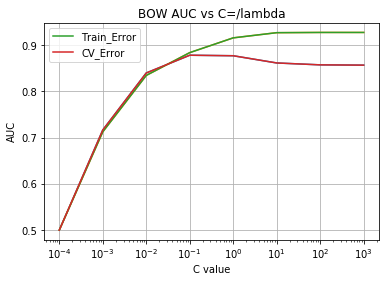

In [44]:
# plot misclassification error vs k 
plot_train_cv_error(returned_pram,returned_pram_train,'BOW AUC vs C=/lambda',C)
plt.show()

**Observation**

We can see that when C value is low, then our model is underfitting, means low AUC on train and low AUC on unseen data. As C increasing AUC on Unseen data increasing till best hyperparamter c=0.1 after that model started overfitting so AUC on Test data started decreasing, while AUC of training data keep increasing. Hence our best C is 0.1. 

In [11]:
from sklearn.linear_model import LogisticRegression
best_C=0.1
LGR = LogisticRegression(C=best_C, penalty='l1')
LGR.fit(training_count, train_traget)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [46]:
from sklearn.linear_model import LogisticRegression
best_C=0.1
LGR = LogisticRegression(C=best_C, penalty='l1')
LGR.fit(training_count, train_traget)
# Prediction on Test data
pred = LGR.predict(test_count)
acc = accuracy_score(test_target, pred, normalize=True) * float(100)
auc=roc_auc_score(test_target, pred)
print(" Alpha C: ",best_C," AUC: ",auc," Acc: ",acc)

 Alpha C:  0.1  AUC:  0.874  Acc:  87.4


In [48]:
# ROC AUC Curve
y_true_train = train_traget
y_probas_train = LGR.predict_proba(training_count)
y_true_test = test_target
y_probas_test = LGR.predict_proba(test_count)

In [176]:
def plot_train_test_ROC(y_true_train,clf,y_true_test,training_count,test_count):
    # ROC AUC Curve
    y_true_train = train_traget
    y_probas_train = clf.predict_proba(training_count)
    y_true_test = test_target
    y_probas_test = clf.predict_proba(test_count)
    fpr1, tpr1, _ = metrics.roc_curve(y_true_train,  y_probas_train[:,1])
    auc1 = metrics.roc_auc_score(y_true_train, y_probas_train[:,1])
    plt.plot(fpr1,tpr1,label="Train AUC, auc="+str(auc1))
    fpr2, tpr2, _ = metrics.roc_curve(y_true_test,  y_probas_test[:,1])
    auc2 = metrics.roc_auc_score(y_true_test, y_probas_test[:,1])
    plt.plot(fpr2,tpr2,label="Test, auc="+str(auc2))
    plt.legend(loc=4)
    plt.title("Train and Test AUC")
    plt.grid()
    plt.xlabel('False Positive rate')
    plt.ylabel('True positive rate')
    return plt
    

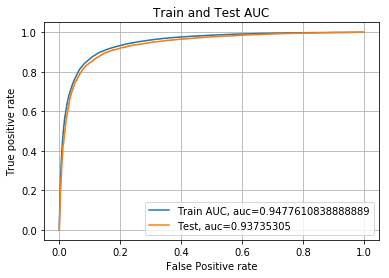

In [50]:
plot_train_test_ROC(y_true_train,clf,y_true_test,training_count,test_count)
plt.show()

**Observation**

We can see that the Train and Test ROC plot is almost overlapping on best hyperparamter C =0.1. And the diff of train and Test AUC is not significant so we can say that this model is well fit. If we need better performance than this we may need to try different models and add some new features


In [147]:
# Plotting Confusion matrix on test data
# Plotting Confusion matrix on test data
import seaborn as sn
from sklearn.metrics import confusion_matrix

def plotconfusionMatrix(y_true_test,clf,test_count):
    ax= plt.subplot()
    confm = confusion_matrix(y_true_test, clf.predict(test_count))
    sns.heatmap(confm, annot=True, ax = ax,annot_kws={"size": 16},fmt="d"); #annot=True to annotate cells
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix of Test data'); 
    ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1'])

[Text(0,0.5,'0'), Text(0,1.5,'1')]

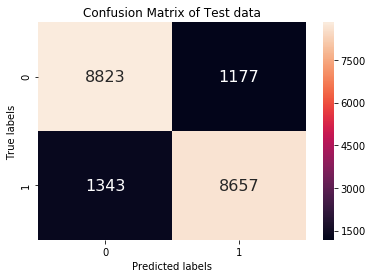

In [52]:
plotconfusionMatrix(y_true_test,LGR,test_count)

**Observation**

We can see that on unseen data(Test set) our diagonal elements have more no of count than off diagonals. means we have more TP and TN than FP and FN.If we need better performance than this, i.e to reduce further FP and FN and increase TP and TN then we may need to try different models and add some new features.


# Sparsity

In [12]:
LGR_l2 = LogisticRegression(C=best_C, penalty='l2')
LGR_l2.fit(training_count, train_traget)
w_2 = LGR_l2.coef_
print("Total No of features of dataset: ",training_counts.shape[1],"=> No of non zero features after L2 reg: ",np.count_nonzero(w_2))

Total No of features of dataset:  1000 => No of non zero features after L2 reg:  1000


In [13]:
LGR = LogisticRegression(C=best_C, penalty='l1')
LGR.fit(training_count, train_traget)
w = LGR.coef_
print("Total No of features of dataset: ",training_counts.shape[1],"=> No of non zero features after L1 reg: ",np.count_nonzero(w))

Total No of features of dataset:  1000 => No of non zero features after L1 reg:  756


In [14]:
# Sparccity % on weight vector
Sparcity_percent=(np.count_nonzero(w_2)-np.count_nonzero(w))/np.count_nonzero(w)
print("Sparcity_percent",Sparcity_percent*100)

Sparcity_percent 32.27513227513227


In [15]:
# Find the unimportant features
feature_data=pd.DataFrame(list(LGR.coef_.T),columns=['l1_weights'])
feature_data['Feature_name']=count_vect.get_feature_names()

In [16]:
unimportant_features=feature_data[feature_data['l1_weights']==0]['Feature_name']

In [19]:
len(unimportant_features)

244

In [21]:
# Unimportant features whose weights are 0 using L1 regularization
unimportant_features[:20]

2       accord
5           ad
9        admit
17      almond
21     alreadi
23      altern
24    although
28    american
32      anymor
50         ate
60         bag
64      banana
67        base
71        bean
76        beef
77      believ
79       berri
82     beverag
85     biscuit
91       blend
Name: Feature_name, dtype: object

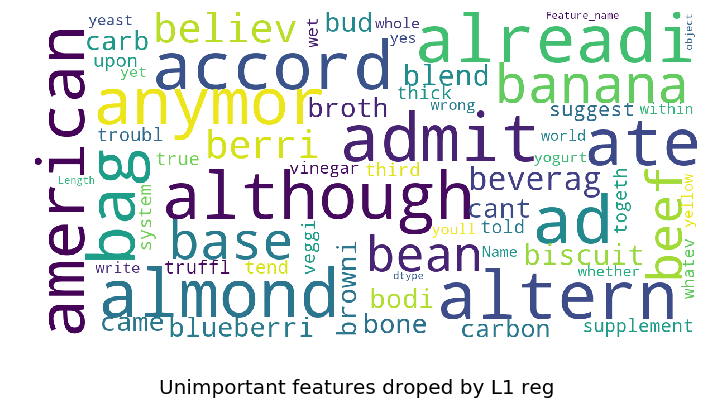

In [134]:
show_wordcloud(unimportant_features,"Unimportant features droped by L1 reg")

**OBSERVATION**

We can see thet, l1 regularizer gave 32.3% more sparse features, i.e removed 32% of the unimportant features. The removed features we can see in the above wordcloud.

# Pertubation Test

In [11]:
training_counts.shape

(60000, 1000)

In [12]:
e=np.random.uniform(0,0.01,(60000,1000))

In [13]:
perturb_data=training_counts+e

In [14]:
perturb_data.shape

(60000, 1000)

In [15]:
LGR_perturb = LogisticRegression(C=best_C, penalty='l1',n_jobs=-1)
LGR_perturb.fit(perturb_data, train_traget)

C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [16]:
wp=LGR_perturb.coef_

In [17]:
np.count_nonzero(wp)

758

In [18]:
print(LGR.coef_.T.shape)
features=(count_vect.get_feature_names())
print(len(features))

(1000, 1)
1000


In [19]:
feature_data=pd.DataFrame(list(LGR.coef_.T),columns=['true_weights'])
feature_data['Feature_name']=features
feature_data['perturb_weights']=LGR_perturb.coef_.T
feature_data.head()

,true_weights,Feature_name,perturb_weights
0,0.156082,abl,0.157145
1,0.108217,absolut,0.109398
2,0.000000,accord,0.000000
3,-0.197147,acid,-0.195036
4,0.039085,actual,0.038423


In [20]:
feature_data['true_weights']=feature_data['true_weights']+1e-06
feature_data['perturb_weights']=feature_data['perturb_weights']+1e-06
feature_data['%change']=((feature_data['true_weights']-feature_data['perturb_weights'])/feature_data['true_weights'])*100
feature_data['%change']=np.absolute(feature_data['%change'])
feature_data.head()

,true_weights,Feature_name,perturb_weights,%change
0,0.156083,abl,0.157146,-0.681020
1,0.108218,absolut,0.109399,-1.091028
2,0.000001,accord,0.000001,0.000000
3,-0.197146,acid,-0.195035,1.071271
4,0.039086,actual,0.038424,1.694961


In [82]:
feature_data.sort_values(by='%change',inplace=True,ascending=False)
feature_data.head()

,true_weights,Feature_name,perturb_weights,%change
576,0.000001,nutrit,-0.002089,209007.165536
306,0.000001,fact,-0.001660,166121.807915
209,0.000001,cover,0.000499,49842.871121
447,0.000947,italian,0.008611,809.413484
781,-0.000106,simpli,-0.000455,327.578741


In [83]:
import scipy.stats as scs
percentile= [scs.percentileofscore(feature_data['%change'].values, i) for i in feature_data['%change'].values]

In [88]:
feature_data['percentile_change']=percentile
feature_data.head()

,true_weights,Feature_name,perturb_weights,%change,percentile_change
576,0.000001,nutrit,-0.002089,209007.165536,100.0
306,0.000001,fact,-0.001660,166121.807915,99.9
209,0.000001,cover,0.000499,49842.871121,99.8
447,0.000947,italian,0.008611,809.413484,99.7
781,-0.000106,simpli,-0.000455,327.578741,99.6


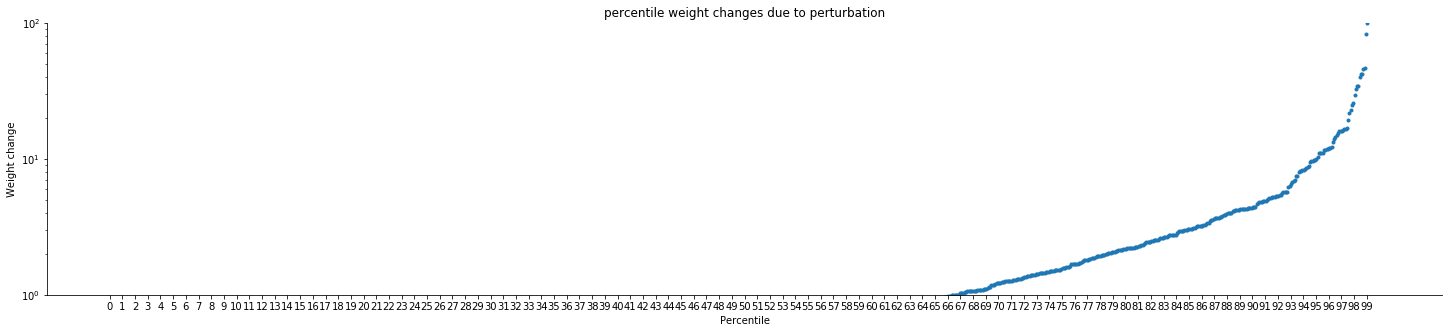

In [80]:
import probscale
import numpy
from matplotlib import pyplot
import seaborn

position, change = probscale.plot_pos(feature_data['%change'])
position *= 100
fig, ax = pyplot.subplots(figsize=(25, 5))
ax.plot(position, change, marker='.', linestyle='none', label='Weight change Change')
ax.set_xlabel('Percentile')
ax.set_ylabel('Weight change')
ax.set_yscale('log')
ax.set_xticks(list(range(100)))
ax.set_ylim(bottom=1, top=100)
plt.title("percentile weight changes due to perturbation")
seaborn.despine()

In [95]:
# index of 67 percentile
feature_data['percentile_change'][330:331]

334    67.0
Name: percentile_change, dtype: float64

**Observation**

We can see that the sudden change of weight from 67 percentile, it means these features are colleaner features. Words which comes under high changes are first 330 words of our sorting df in descending order . Below wordclod contains all the collener words.

In [97]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()


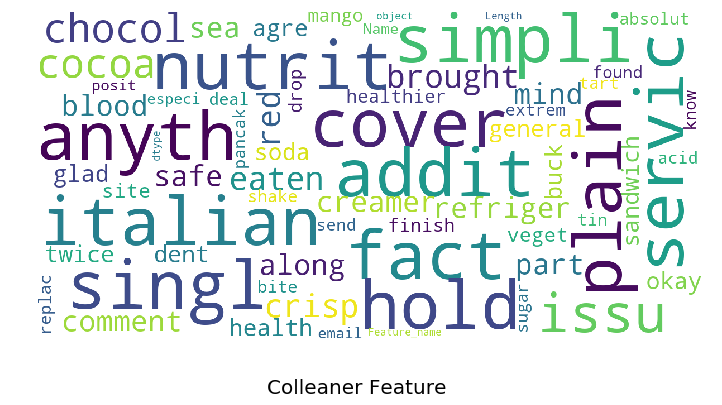

In [98]:
show_wordcloud(str(feature_data['Feature_name'][:330]),"Colleaner Feature")

In [99]:
# Name of collenear features
str(feature_data['Feature_name'][:330])

'576       nutrit\n306         fact\n209        cover\n447      italian\n781       simpli\n783        singl\n639        plain\n34         anyth\n413         hold\n8          addit\n763       servic\n446         issu\n171        cocoa\n161       chocol\n113      brought\n217        crisp\n276        eaten\n703          red\n706     refriger\n179      comment\n92         blood\n214      creamer\n20         along\n747          sea\n534         mind\n733         safe\n615         part\n360      general\n13          agre\n400       health\n         ...    \n921        twice\n741     sandwich\n586         okay\n366         glad\n116         buck\n798         soda\n242         dent\n937        veget\n786         site\n402    healthier\n514        mango\n328       finish\n269         drop\n1        absolut\n343        found\n714       replac\n233         deal\n3           acid\n758         send\n851        sugar\n305       extrem\n87          bite\n613       pancak\n464         know\n766      

In [95]:
# Removing the collenear features
train_collenear=pd.DataFrame(training_counts.toarray())
train_collenear.columns=features=(count_vect.get_feature_names())
train_collenear.head(1)

,abl,absolut,accord,acid,actual,ad,add,addict,addit,admit,...,yeast,yellow,yes,yet,yogurt,youll,your,youv,yummi,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [93]:
train_collenear.shape

(60000, 1000)

In [97]:
train_collenear.drop(feature_data['Feature_name'][:50], axis=1, inplace=True)

In [115]:
# Removed collenear features and training on non collenear features
LGR = LogisticRegression(C=best_C, penalty='l1')
LGR.fit(train_collenear, train_traget)
train_collenear.shape

(60000, 950)

# Feature Importance

In [106]:
feature_data=pd.DataFrame(list(LGR.coef_.T),columns=['true_weights'])
feature_data['Feature_name']=features

In [105]:
# Important features for +ve review
feature_data.sort_values(by='true_weights',inplace=True,ascending=False)
feature_data.head()

,true_weights,Feature_name
238,1.449522,delici
73,1.343873,beat
296,1.321079,excel
979,1.240329,worri
26,1.156124,amaz


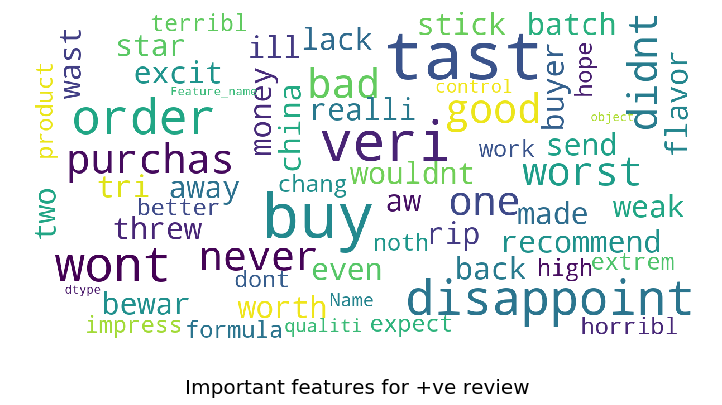

In [261]:
# Important features for +ve review
#feature_data1.sort_values(by='true_weights',inplace=True,ascending=False)
# Word cloud of Important features for +ve review
show_wordcloud(str(feature_data['Feature_name'][:50]),"Important features for +ve review")

**Observation**

We can see that all the positive words in the above word cloud like testi, best, awesom so these words are important features for positive review. 

In [146]:
# Important features for -ve review
feature_data1.sort_values(by='true_weights',inplace=True,ascending=True)
feature_data1.head()

,true_weights,Feature_name
981,-2.542015,worst
53,-1.943514,aw
875,-1.710588,terribl
869,-1.554359,tasteless
419,-1.464923,horribl


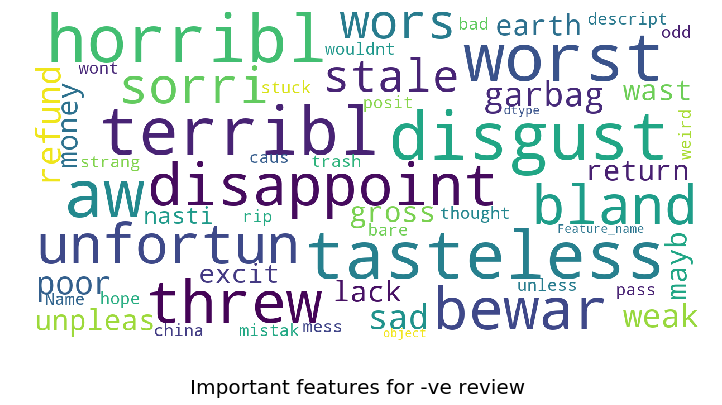

In [147]:
# Word cloud of Important features for +ve review
show_wordcloud(str(feature_data['Feature_name'][:50]),"Important features for -ve review")

**Observation**

We can see that all the negative words in the above wordcloud like tasteless, worst, refurnd so these words are important features for negative review. 

# Feature Engineering

- Creating 4 new features using word and character len of description and summary columns

In [251]:
import pandas as pd
data=pd.DataFrame(training_count)
data.head(3)

,0,1,2,3,4,5,6,7,8,9,...,6850,6851,6852,6853,6854,6855,6856,6857,6858,6859
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [252]:
data.shape

(60000, 6860)

In [254]:
#Train data
# word len of description and summary columns
data['description_len'] = train_text_data['CleanedText'].apply(lambda x : len(x.split()))
data['summary_len'] = train_text_data['Summary'].apply(lambda x : len(x.split()))

# charater len of description and summary columns
data['description_char_len'] = train_text_data['CleanedText'].apply(len)
data['Summary_char_len'] = train_text_data['Summary'].apply(len)


In [255]:
data.head(1)

,0,1,2,3,4,5,6,7,8,9,...,6854,6855,6856,6857,6858,6859,description_len,summary_len,description_char_len,Summary_char_len
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,11,1,61,5


In [256]:
data.shape

(60000, 6864)

In [257]:
#Test data
# word len of description and summary columns
data_test=pd.DataFrame(test_count)
data_test['description_len'] = test_text_data['CleanedText'].apply(lambda x : len(x.split()))
data_test['summary_len'] = test_text_data['Summary'].apply(lambda x : len(x.split()))

# charater len of description and summary columns
data_test['description_char_len'] = test_text_data['CleanedText'].apply(len)
data_test['Summary_char_len'] = test_text_data['Summary'].apply(len)
data_test.head(1)

,0,1,2,3,4,5,6,7,8,9,...,6854,6855,6856,6857,6858,6859,description_len,summary_len,description_char_len,Summary_char_len
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,29,2,163,7


In [258]:
data_test.shape

(20000, 6864)

In [259]:
# with l1 regularizer
from sklearn.linear_model import LogisticRegression
best_C=0.1
LGR = LogisticRegression(C=best_C, penalty='l1')
LGR.fit(data, train_traget)
# Prediction on Test data
pred = LGR.predict(data_test)
acc = accuracy_score(test_target, pred, normalize=True) * float(100)
auc=roc_auc_score(test_target, pred)
print(" Alpha C: ",best_C," AUC: ",auc," Acc: ",acc)

 Alpha C:  0.1  AUC:  0.8738499999999999  Acc:  87.385


In [260]:
# with l2 regularizer
from sklearn.linear_model import LogisticRegression
best_C=0.1
LGR = LogisticRegression(C=best_C, penalty='l2',n_jobs=-1)
LGR.fit(data, train_traget)
# Prediction on Test data
pred = LGR.predict(data_test)
acc = accuracy_score(test_target, pred, normalize=True) * float(100)
auc=roc_auc_score(test_target, pred)
print(" Alpha C: ",best_C," AUC: ",auc," Acc: ",acc)

C:\Users\Sanjay\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


 Alpha C:  0.1  AUC:  0.8799500000000001  Acc:  87.995


**Observation**

After adding the 4 new features, performance does not changed much with both l1 and l2 regularizer, earlier we have 87 to 88% AUC and after feature engineering we are getting almost same.


# Applying Logistic Regression with L2 regularization on BOW, SET 1

In [161]:
# Compute train AUC also

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
#Simple Cross Validation
C=[0.0001,0.001,0.01,0.1,1,10,100,1000,]
returned_pram=dict()
returned_pram_train=dict()
for i in tqdm(C):
    # instantiate learning model
    LGR = LogisticRegression(C=i, penalty='l2',n_jobs=-1)

    # fitting the model on crossvalidation train
    LGR.fit(training_count, train_traget)

    # predict the response on the crossvalidation train
    pred_cv = LGR.predict(cv_count)

    # evaluate CV accuracy
    acc_cv = accuracy_score(cv_target, pred_cv, normalize=True) * float(100)
    auc_cv=roc_auc_score(cv_target, pred_cv)
    auc_train=roc_auc_score(train_traget, LGR.predict(training_count))
    print(" C value: ",i," AUC: ",auc_cv," Acc: ",acc_cv," auc_train ",auc_train)
    returned_pram.update({i:auc_cv})
    returned_pram_train.update({i:auc_train})
    gc.collect()
    

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]C:\Users\Sanjay\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


 C value:  0.0001  AUC:  0.7951  Acc:  79.51  auc_train  0.7970666666666667


 12%|██████████▌                                                                         | 1/8 [00:05<00:39,  5.67s/it]C:\Users\Sanjay\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


 C value:  0.001  AUC:  0.84595  Acc:  84.595  auc_train  0.8473499999999999


 25%|█████████████████████                                                               | 2/8 [00:11<00:34,  5.79s/it]C:\Users\Sanjay\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


 C value:  0.01  AUC:  0.8729999999999999  Acc:  87.3  auc_train  0.8810666666666667


 38%|███████████████████████████████▌                                                    | 3/8 [00:18<00:29,  5.97s/it]C:\Users\Sanjay\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


 C value:  0.1  AUC:  0.8801  Acc:  88.01  auc_train  0.9027833333333333


 50%|██████████████████████████████████████████                                          | 4/8 [00:25<00:25,  6.28s/it]C:\Users\Sanjay\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


 C value:  1  AUC:  0.8753500000000002  Acc:  87.535  auc_train  0.9186166666666669


 62%|████████████████████████████████████████████████████▌                               | 5/8 [00:37<00:24,  8.01s/it]C:\Users\Sanjay\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


 C value:  10  AUC:  0.86955  Acc:  86.955  auc_train  0.9224166666666667


 75%|███████████████████████████████████████████████████████████████                     | 6/8 [00:55<00:22, 11.23s/it]C:\Users\Sanjay\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


 C value:  100  AUC:  0.8693000000000001  Acc:  86.92999999999999  auc_train  0.9225500000000001


 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [01:13<00:13, 13.26s/it]C:\Users\Sanjay\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


 C value:  1000  AUC:  0.86935  Acc:  86.935  auc_train  0.92275


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:31<00:00, 14.43s/it]


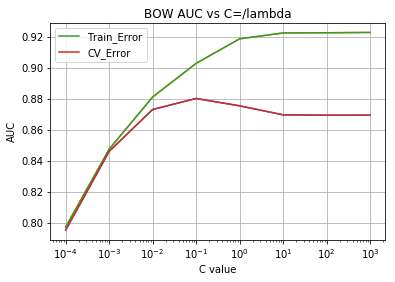

In [162]:
# plot misclassification error vs k 
plot_train_cv_error(returned_pram,returned_pram_train,'BOW AUC vs C=/lambda',C)
plt.show()

**Observation**
We can see that when C value is low, then our model is underfitting, means low AUC on train and low AUC on unseen data. As C increasing AUC on Unseen data increasing till best hyperparamter c=0.1 after that model started overfitting so AUC on Test data started decreasing, while AUC of training data keep increasing. Hence our best C is 0.1 for l2 regularizer. 

In [164]:
from sklearn.linear_model import LogisticRegression
best_C=0.1
LGR = LogisticRegression(C=best_C, penalty='l2')
LGR.fit(training_count, train_traget)
# Prediction on Test data
pred = LGR.predict(test_count)
acc = accuracy_score(test_target, pred, normalize=True) * float(100)
auc=roc_auc_score(test_target, pred)
print(" Alpha C: ",best_C," AUC: ",auc," Acc: ",acc)

 Alpha C:  0.1  AUC:  0.8797999999999999  Acc:  87.98


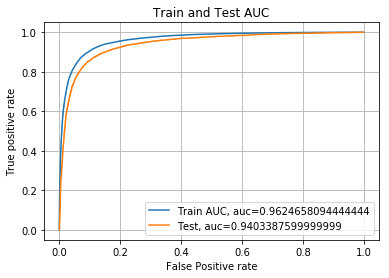

In [165]:
plot_train_test_ROC(y_true_train,LGR,y_true_test,training_count,test_count)
plt.show()

**Observation**

We can see that the Train and Test ROC plot is almost overlapping on best hyperparamter C =0.1. And the diff of train and Test AUC is not significant so we can say that this model is well fit. If we need better performance than this we may need to try different models and add some new features

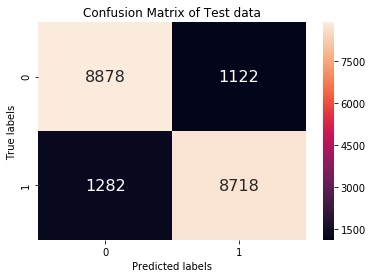

In [166]:
plotconfusionMatrix(y_true_test,LGR,test_count)


**Observation**

We can see that on unseen data(Test set) our diagonal elements have more no of count than off diagonals. means we have more TP and TN than FP and FN.If we need better performance than this, i.e to reduce further FP and FN and increase TP and TN then we may need to try different models and add some new features.

# [5.2] Logistic Regression on TFIDF, SET 2

**[5.2.1] Applying Logistic Regression with L1 regularization on TFIDF, SET 2**

In [167]:
tf_idf_vect = TfidfVectorizer(ngram_range=(2,3),min_df=10,max_features=10000)
training_counts = tf_idf_vect.fit_transform(train_text_data['CleanedText'])
cv_counts = tf_idf_vect.transform(cv_text_data['CleanedText'])
test_counts = tf_idf_vect.transform(test_text_data['CleanedText'])

In [168]:
print(" training_counts ",training_counts.shape,"cv_counts ",cv_counts.shape,"test_counts",test_counts.shape)
# converting sparse vector to dense vector
training_count=training_counts.toarray()
cv_count=cv_counts.toarray()
test_count=test_counts.toarray()
# removing unused object
gc.collect()

 training_counts  (60000, 10000) cv_counts  (20000, 10000) test_counts (20000, 10000)


18795

In [169]:
train_traget=train_text_data['Score'].astype('int')
cv_target=cv_text_data['Score'].astype('int')
test_target=test_text_data['Score'].astype('int')

In [140]:
# Compute train AUC also

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
#Simple Cross Validation
C=[0.0001,0.001,0.01,0.1,1,10,100,1000,]
returned_pram=dict()
returned_pram_train=dict()
for i in tqdm(C):
    # instantiate learning model
    LGR = LogisticRegression(C=i, penalty='l1',n_jobs=-1)

    # fitting the model on crossvalidation train
    LGR.fit(training_count, train_traget)

    # predict the response on the crossvalidation train
    pred_cv = LGR.predict(cv_count)

    # evaluate CV accuracy
    acc_cv = accuracy_score(cv_target, pred_cv, normalize=True) * float(100)
    auc_cv=roc_auc_score(cv_target, pred_cv)
    auc_train=roc_auc_score(train_traget, LGR.predict(training_count))
    print(" C value: ",i," AUC: ",auc_cv," Acc: ",acc_cv," auc_train ",auc_train)
    returned_pram.update({i:auc_cv})
    returned_pram_train.update({i:auc_train})
    gc.collect()
    

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]C:\Users\Sanjay\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


 C value:  0.0001  AUC:  0.5  Acc:  50.0  auc_train  0.5


 12%|██████████▌                                                                         | 1/8 [00:04<00:30,  4.31s/it]C:\Users\Sanjay\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


 C value:  0.001  AUC:  0.5  Acc:  50.0  auc_train  0.5


 25%|█████████████████████                                                               | 2/8 [00:07<00:23,  3.90s/it]C:\Users\Sanjay\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


 C value:  0.01  AUC:  0.5921000000000001  Acc:  59.209999999999994  auc_train  0.5852666666666666


 38%|███████████████████████████████▌                                                    | 3/8 [00:10<00:18,  3.64s/it]C:\Users\Sanjay\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


 C value:  0.1  AUC:  0.7502  Acc:  75.02  auc_train  0.7464


 50%|██████████████████████████████████████████                                          | 4/8 [00:13<00:13,  3.48s/it]C:\Users\Sanjay\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


 C value:  1  AUC:  0.85025  Acc:  85.02499999999999  auc_train  0.8835166666666667


 62%|████████████████████████████████████████████████████▌                               | 5/8 [00:16<00:10,  3.38s/it]C:\Users\Sanjay\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


 C value:  10  AUC:  0.8381500000000001  Acc:  83.815  auc_train  0.9224333333333333


 75%|███████████████████████████████████████████████████████████████                     | 6/8 [00:19<00:06,  3.29s/it]C:\Users\Sanjay\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


 C value:  100  AUC:  0.8258000000000001  Acc:  82.58  auc_train  0.92655


 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [00:23<00:03,  3.38s/it]C:\Users\Sanjay\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


 C value:  1000  AUC:  0.8238500000000001  Acc:  82.38499999999999  auc_train  0.92645


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:28<00:00,  3.91s/it]


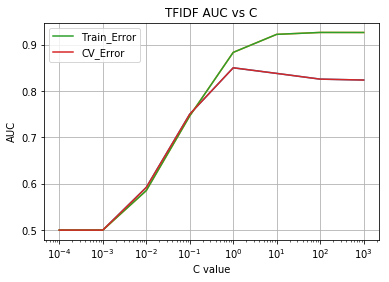

In [142]:
# plot misclassification error vs C 
plot_train_cv_error(returned_pram,returned_pram_train,'TFIDF AUC vs C',C)
plt.show()

**Observation**
We can see that when C value is low, then our model is underfitting, means low AUC on train and low AUC on unseen data. As C increasing AUC on Unseen data increasing till best hyperparamter c=1 after that model started overfitting so AUC on Test data started decreasing, while AUC of training data keep increasing. Hence our best C is 1. 

In [144]:
from sklearn.linear_model import LogisticRegression
best_C=1
LGR = LogisticRegression(C=best_C, penalty='l1')
LGR.fit(training_count, train_traget)
# Prediction on Test data
pred = LGR.predict(test_count)
acc = accuracy_score(test_target, pred, normalize=True) * float(100)
auc=roc_auc_score(test_target, pred)
print(" Alpha C: ",best_C," AUC: ",auc," Acc: ",acc)

 Alpha C:  1  AUC:  0.84865  Acc:  84.865


In [145]:
y_true_train = train_traget
y_probas_train = LGR.predict_proba(training_count)
y_true_test = test_target
y_probas_test = LGR.predict_proba(test_count)

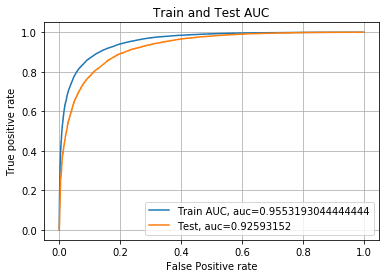

In [148]:
plot_train_test_ROC(y_true_train,y_probas_train,y_true_test,y_probas_test)
plt.show()

**Observation**

We can see that the Train and Test ROC plot is almost overlapping on best hyperparamter C =1. And the diff of train and Test AUC is not significant so we can say that this model is well fit. If we need better performance than this we may need to try different models and add some new features

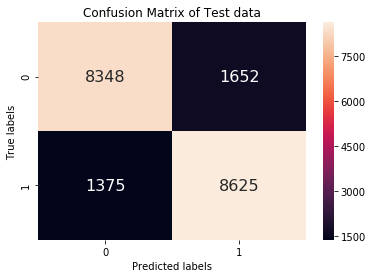

In [149]:
# Confusion matrix
plotconfusionMatrix(y_true_test,LGR,test_count)

**Observation**

We can see that on unseen data(Test set) our diagonal elements have more no of count than off diagonals. means we have more TP and TN than FP and FN.If we need better performance than this, i.e to reduce further FP and FN and increase TP and TN then we may need to try different models and add some new features.

**[5.2.1] Applying Logistic Regression with L2 regularization on TFIDF, SET 2**

In [170]:
# Compute train AUC also

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
#Simple Cross Validation
C=[0.0001,0.001,0.01,0.1,1,10,100,1000,]
returned_pram=dict()
returned_pram_train=dict()
for i in tqdm(C):
    # instantiate learning model
    LGR = LogisticRegression(C=i, penalty='l2',n_jobs=-1)

    # fitting the model on crossvalidation train
    LGR.fit(training_count, train_traget)

    # predict the response on the crossvalidation train
    pred_cv = LGR.predict(cv_count)

    # evaluate CV accuracy
    acc_cv = accuracy_score(cv_target, pred_cv, normalize=True) * float(100)
    auc_cv=roc_auc_score(cv_target, pred_cv)
    auc_train=roc_auc_score(train_traget, LGR.predict(training_count))
    print(" C value: ",i," AUC: ",auc_cv," Acc: ",acc_cv," auc_train ",auc_train)
    returned_pram.update({i:auc_cv})
    returned_pram_train.update({i:auc_train})
    gc.collect()
    

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]C:\Users\Sanjay\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


 C value:  0.0001  AUC:  0.81865  Acc:  81.865  auc_train  0.8306333333333333


 12%|██████████▌                                                                         | 1/8 [00:03<00:27,  3.97s/it]C:\Users\Sanjay\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


 C value:  0.001  AUC:  0.81565  Acc:  81.565  auc_train  0.82595


 25%|█████████████████████                                                               | 2/8 [00:06<00:22,  3.68s/it]C:\Users\Sanjay\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


 C value:  0.01  AUC:  0.82185  Acc:  82.185  auc_train  0.8322833333333333


 38%|███████████████████████████████▌                                                    | 3/8 [00:09<00:17,  3.47s/it]C:\Users\Sanjay\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


 C value:  0.1  AUC:  0.8426  Acc:  84.26  auc_train  0.8596666666666667


 50%|██████████████████████████████████████████                                          | 4/8 [00:13<00:13,  3.35s/it]C:\Users\Sanjay\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


 C value:  1  AUC:  0.8550000000000001  Acc:  85.5  auc_train  0.8947333333333334


 62%|████████████████████████████████████████████████████▌                               | 5/8 [00:16<00:09,  3.31s/it]C:\Users\Sanjay\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


 C value:  10  AUC:  0.8464499999999999  Acc:  84.64500000000001  auc_train  0.9153666666666667


 75%|███████████████████████████████████████████████████████████████                     | 6/8 [00:19<00:06,  3.36s/it]C:\Users\Sanjay\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


 C value:  100  AUC:  0.83155  Acc:  83.155  auc_train  0.92415


 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [00:23<00:03,  3.57s/it]C:\Users\Sanjay\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


 C value:  1000  AUC:  0.82475  Acc:  82.475  auc_train  0.9266666666666666


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:28<00:00,  3.95s/it]


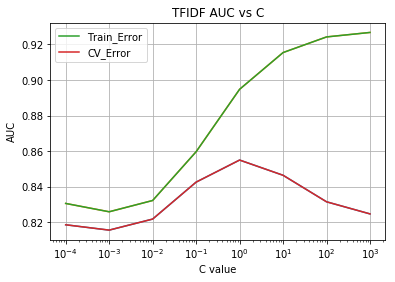

In [171]:
# plot misclassification error vs C 
plot_train_cv_error(returned_pram,returned_pram_train,'TFIDF AUC vs C',C)
plt.show()

**Observation**
We can see that when C value is low, then our model is underfitting, means low AUC on train and low AUC on unseen data. As C increasing AUC on Unseen data increasing till best hyperparamter c=1 after that model started overfitting so AUC on Test data started decreasing, while AUC of training data keep increasing. Hence our best C is 1 for l2 regularizer.

In [172]:
from sklearn.linear_model import LogisticRegression
best_C=1
LGR = LogisticRegression(C=best_C, penalty='l2')
LGR.fit(training_count, train_traget)
# Prediction on Test data
pred = LGR.predict(test_count)
acc = accuracy_score(test_target, pred, normalize=True) * float(100)
auc=roc_auc_score(test_target, pred)
print(" Alpha C: ",best_C," AUC: ",auc," Acc: ",acc)

 Alpha C:  1  AUC:  0.8547  Acc:  85.47


In [173]:
y_true_train = train_traget
y_probas_train = LGR.predict_proba(training_count)
y_true_test = test_target
y_probas_test = LGR.predict_proba(test_count)

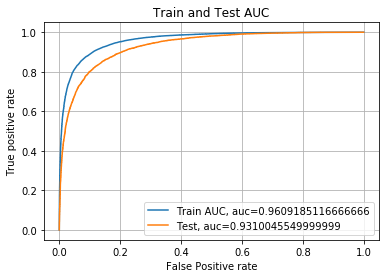

In [179]:
plot_train_test_ROC(y_true_train,LGR,y_true_test,training_count,test_count)
plt.show()

**Observation**

We can see that the Train and Test ROC plot is almost overlapping on best hyperparamter C =1. And the diff of train and Test AUC is not significant so we can say that this model is well fit. If we need better performance than this we may need to try different models and add some new features

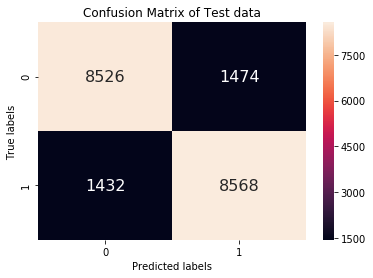

In [180]:
# Confusion matrix
plotconfusionMatrix(y_true_test,LGR,test_count)

**Observation**

We can see that on unseen data(Test set) our diagonal elements have more no of count than off diagonals. means we have more TP and TN than FP and FN.If we need better performance than this, i.e to reduce further FP and FN and increase TP and TN then we may need to try different models and add some new features.

In [3]:
# Please write all the code with proper documentation

### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [185]:
# Please write all the code with proper documentation
feature_data=pd.DataFrame(list(LGR.coef_.T),columns=['true_weights'])
feature_data['Feature_name']=tf_idf_vect.get_feature_names()
feature_data.head()

,true_weights,Feature_name
0,1.957826,abl buy
1,0.057615,abl drink
2,-0.252452,abl eat
3,0.416811,abl enjoy
4,2.041608,abl find


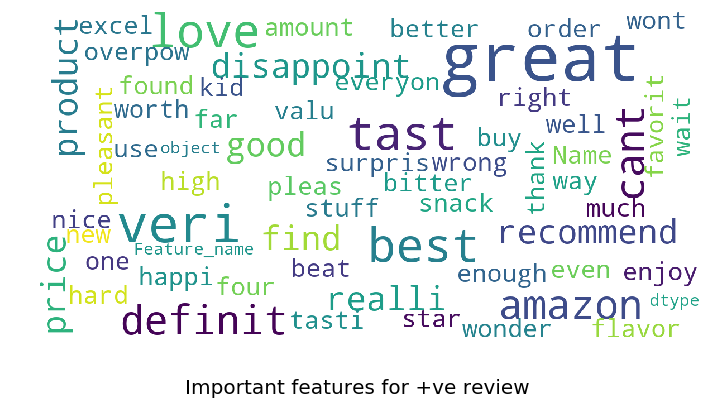

In [186]:
# Important features for +ve review
feature_data.sort_values(by='true_weights',inplace=True,ascending=False)
# Word cloud of Important features for +ve review
show_wordcloud(str(feature_data['Feature_name'][:50]),"Important features for +ve review")


**Observation**

We can see that most of the positive words in the above wordcloud like best, great, love so these words are important features for positive review. 

#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

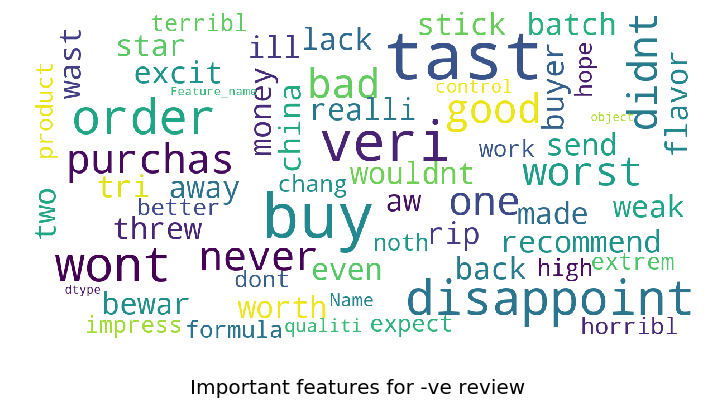

In [190]:
# Please write all the code with proper documentation
# Important features for -ve review
feature_data.sort_values(by='true_weights',inplace=True,ascending=True)
# Word cloud of Important features for +ve review
show_wordcloud(str(feature_data['Feature_name'][:50]),"Important features for -ve review")


**Observation**

We can see that most of the negative words in the above wordcloud like tasteless, worst, refurnd so these words are important features for negative review. 

## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

In [234]:
# Please write all the code with proper documentation
#train_avg_w2v_data,cv_avg_w2v_data,test_avg_w2v_data
train_traget=train_avg_w2v_data['Score'].astype('int')
cv_target=cv_avg_w2v_data['Score'].astype('int')
test_target=test_avg_w2v_data['Score'].astype('int')

train_data = train_avg_w2v_data.iloc[:,:-2]
cv_data = cv_avg_w2v_data.iloc[:,:-2]
test_data = test_avg_w2v_data.iloc[:,:-2]

In [195]:
train_avg_w2v_data.head(1)

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,Score,Time
18000,-0.072261,-0.631519,1.198363,0.29545,0.123251,-1.53865,0.494211,0.498906,-0.04214,-0.516918,...,0.558099,-0.098661,-0.087573,1.054245,1.093834,0.375699,0.012794,0.076482,0.0,948240000.0


In [201]:
# Compute train AUC also

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
#Simple Cross Validation
C=[0.0001,0.001,0.01,0.1,1,10,100,1000,]
returned_pram=dict()
returned_pram_train=dict()
for i in tqdm(C):
    # instantiate learning model
    LGR = LogisticRegression(C=i, penalty='l1',n_jobs=-1)

    # fitting the model on crossvalidation train
    LGR.fit(train_data, train_traget)

    # predict the response on the crossvalidation train
    pred_cv = LGR.predict(cv_data)

    # evaluate CV accuracy
    acc_cv = accuracy_score(cv_target, pred_cv, normalize=True) * float(100)
    auc_cv=roc_auc_score(cv_target, pred_cv)
    auc_train=roc_auc_score(train_traget, LGR.predict(train_data))
    print(" C value: ",i," AUC: ",auc_cv," Acc: ",acc_cv," auc_train ",auc_train)
    returned_pram.update({i:auc_cv})
    returned_pram_train.update({i:auc_train})
    gc.collect()
    

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]C:\Users\Sanjay\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


 C value:  0.0001  AUC:  0.5  Acc:  50.0  auc_train  0.5


 12%|██████████▌                                                                         | 1/8 [00:00<00:02,  3.05it/s]C:\Users\Sanjay\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


 C value:  0.001  AUC:  0.5  Acc:  50.0  auc_train  0.5


 25%|█████████████████████                                                               | 2/8 [00:00<00:01,  3.18it/s]C:\Users\Sanjay\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


 C value:  0.01  AUC:  0.4979166666666667  Acc:  49.791666666666664  auc_train  0.506


 38%|███████████████████████████████▌                                                    | 3/8 [00:00<00:01,  3.14it/s]C:\Users\Sanjay\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


 C value:  0.1  AUC:  0.5039166666666667  Acc:  50.391666666666666  auc_train  0.5176944444444445


 50%|██████████████████████████████████████████                                          | 4/8 [00:01<00:01,  2.17it/s]C:\Users\Sanjay\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


 C value:  1  AUC:  0.5025  Acc:  50.24999999999999  auc_train  0.5175833333333333


 62%|████████████████████████████████████████████████████▌                               | 5/8 [00:02<00:01,  1.65it/s]C:\Users\Sanjay\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


 C value:  10  AUC:  0.5011666666666665  Acc:  50.11666666666667  auc_train  0.5176666666666667


 75%|███████████████████████████████████████████████████████████████                     | 6/8 [00:16<00:09,  4.62s/it]C:\Users\Sanjay\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


 C value:  100  AUC:  0.5005833333333333  Acc:  50.05833333333334  auc_train  0.5174722222222222


 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [00:32<00:07,  7.96s/it]C:\Users\Sanjay\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


 C value:  1000  AUC:  0.50075  Acc:  50.075  auc_train  0.5176944444444445


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:47<00:00, 10.08s/it]


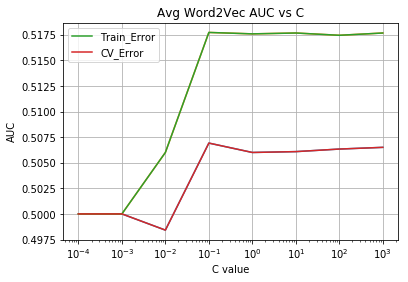

In [198]:
# plot misclassification error vs C 
plot_train_cv_error(returned_pram,returned_pram_train,'Avg Word2Vec AUC vs C',C)
plt.show()

**Observation**
We can see that when C value is low, then our model is underfitting, means low AUC on train and low AUC on unseen data. As C increasing AUC on Unseen data increasing till best hyperparamter c=0.1 after that model started overfitting so AUC on Test data started decreasing, while AUC of training data keep increasing. Hence our best C is 0.1.

In [235]:
from sklearn.linear_model import LogisticRegression
best_C=0.1
LGR = LogisticRegression(C=best_C, penalty='l1')
LGR.fit(train_data, train_traget)
# Prediction on Test data
pred = LGR.predict(test_data)
acc = accuracy_score(test_target, pred, normalize=True) * float(100)
auc=roc_auc_score(test_target, pred)
print(" Alpha C: ",best_C," AUC: ",auc," Acc: ",acc)

 Alpha C:  0.1  AUC:  0.5110833333333333  Acc:  51.108333333333334


In [236]:
y_true_train = train_traget
y_probas_train = LGR.predict_proba(train_data)
y_true_test = test_target
y_probas_test = LGR.predict_proba(test_data)

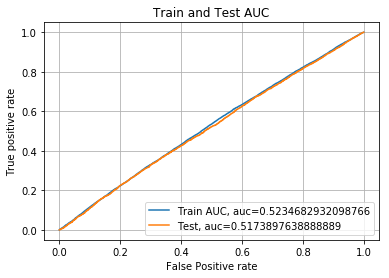

In [237]:
plot_train_test_ROC(y_true_train,LGR,y_true_test,train_data,test_data)
plt.show()

**Observation**

We can see that the Train and Test ROC plot is almost overlapping on best hyperparamter C =0.1. And the diff of train and Test AUC is not significant than random model so we can say existing features are not working hence model is underfitting. If we need better performance than this we may need to add some new useful features

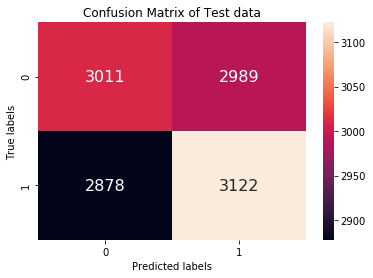

In [238]:
# Confusion matrix
plotconfusionMatrix(y_true_test,LGR,test_data)

**Observation**

We can see that on unseen data(Test set) our diagonal elements have almost similar number than off diagonal with very high no of FP and FN, ie. model is underfitting.If we need better performance than this, i.e to reduce further FP and FN and increase TP and TN then we may need to add some new features.

### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

In [239]:
# Please write all the code with proper documentation
# Compute train AUC also

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
#Simple Cross Validation
C=[0.0001,0.001,0.01,0.1,1,10,100,1000,]
returned_pram=dict()
returned_pram_train=dict()
for i in tqdm(C):
    # instantiate learning model
    LGR = LogisticRegression(C=i, penalty='l2',n_jobs=-1)

    # fitting the model on crossvalidation train
    LGR.fit(train_data, train_traget)

    # predict the response on the crossvalidation train
    pred_cv = LGR.predict(cv_data)

    # evaluate CV accuracy
    acc_cv = accuracy_score(cv_target, pred_cv, normalize=True) * float(100)
    auc_cv=roc_auc_score(cv_target, pred_cv)
    auc_train=roc_auc_score(train_traget, LGR.predict(train_data))
    print(" C value: ",i," AUC: ",auc_cv," Acc: ",acc_cv," auc_train ",auc_train)
    returned_pram.update({i:auc_cv})
    returned_pram_train.update({i:auc_train})
    gc.collect()
    

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]C:\Users\Sanjay\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


 C value:  0.0001  AUC:  0.5065  Acc:  50.64999999999999  auc_train  0.5121944444444444


 12%|██████████▌                                                                         | 1/8 [00:00<00:03,  2.29it/s]C:\Users\Sanjay\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


 C value:  0.001  AUC:  0.5049166666666667  Acc:  50.49166666666667  auc_train  0.5166666666666667


 25%|█████████████████████                                                               | 2/8 [00:00<00:02,  2.29it/s]C:\Users\Sanjay\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


 C value:  0.01  AUC:  0.5009166666666667  Acc:  50.09166666666667  auc_train  0.5173611111111112


 38%|███████████████████████████████▌                                                    | 3/8 [00:01<00:02,  2.01it/s]C:\Users\Sanjay\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


 C value:  0.1  AUC:  0.5015  Acc:  50.14999999999999  auc_train  0.51725


 50%|██████████████████████████████████████████                                          | 4/8 [00:02<00:02,  1.88it/s]C:\Users\Sanjay\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


 C value:  1  AUC:  0.50075  Acc:  50.075  auc_train  0.5173055555555555


 62%|████████████████████████████████████████████████████▌                               | 5/8 [00:02<00:01,  1.80it/s]C:\Users\Sanjay\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


 C value:  10  AUC:  0.5005  Acc:  50.05  auc_train  0.5176666666666666


 75%|███████████████████████████████████████████████████████████████                     | 6/8 [00:03<00:01,  1.75it/s]C:\Users\Sanjay\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


 C value:  100  AUC:  0.5005833333333333  Acc:  50.05833333333334  auc_train  0.517611111111111


 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [00:04<00:00,  1.65it/s]C:\Users\Sanjay\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


 C value:  1000  AUC:  0.5005833333333333  Acc:  50.05833333333334  auc_train  0.5175833333333334


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.67it/s]


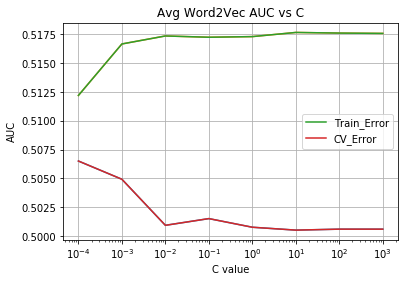

In [240]:
# plot misclassification error vs C 
plot_train_cv_error(returned_pram,returned_pram_train,'Avg Word2Vec AUC vs C',C)
plt.show()

**Observation**
We can see that when C value is low, then our model is underfitting, means low AUC on train and low AUC on unseen data. As C increasing AUC on Unseen data decreasing, while AUC of training data keep increasing. Hence our best C is 0.0001. 

In [241]:
from sklearn.linear_model import LogisticRegression
best_C=0.0001
LGR = LogisticRegression(C=best_C, penalty='l2')
LGR.fit(train_data, train_traget)
# Prediction on Test data
pred = LGR.predict(test_data)
acc = accuracy_score(test_target, pred, normalize=True) * float(100)
auc=roc_auc_score(test_target, pred)
print(" Alpha C: ",best_C," AUC: ",auc," Acc: ",acc)

 Alpha C:  0.0001  AUC:  0.5167499999999999  Acc:  51.675000000000004


In [242]:
y_true_train = train_traget
y_probas_train = LGR.predict_proba(train_data)
y_true_test = test_target
y_probas_test = LGR.predict_proba(test_data)

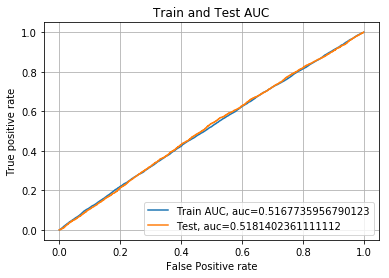

In [243]:
plot_train_test_ROC(y_true_train,LGR,y_true_test,train_data,test_data)
plt.show()


**Observation**

We can see that the Train and Test ROC plot is almost overlapping on best hyperparamter C =0.0001. And the diff of train and Test AUC is not significant than random model so we can say existing features are not working hence model is underfitting. If we need better performance than this we may need to add some new useful features

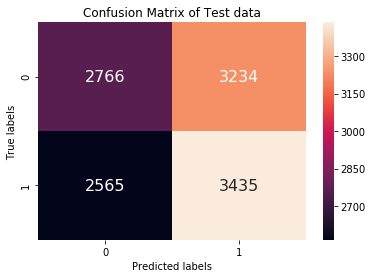

In [244]:
# Confusion matrix
plotconfusionMatrix(y_true_test,LGR,test_data)

**Observation**

We can see that on unseen data(Test set) our diagonal elements have almost similar number than off diagonal with very high no of FP and FN, ie. model is underfitting.If we need better performance than this, i.e to reduce further FP and FN and increase TP and TN then we may need to add some new features.

## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [214]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
#train_avg_w2v_data,cv_avg_w2v_data,test_avg_w2v_data
train_traget=train_tfidf_w2v_data['Score'].astype('int')
cv_target=cv_tfidf_w2v_data['Score'].astype('int')
test_target=test_tfidf_w2v_data['Score'].astype('int')

train_data = train_tfidf_w2v_data.iloc[:,:-2]
cv_data = cv_tfidf_w2v_data.iloc[:,:-2]
test_data = test_tfidf_w2v_data.iloc[:,:-2]

In [215]:
# Compute train AUC also

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
#Simple Cross Validation
C=[0.0001,0.001,0.01,0.1,1,10,100,1000,]
returned_pram=dict()
returned_pram_train=dict()
for i in tqdm(C):
    # instantiate learning model
    LGR = LogisticRegression(C=i, penalty='l1',n_jobs=-1)

    # fitting the model on crossvalidation train
    LGR.fit(train_data, train_traget)

    # predict the response on the crossvalidation train
    pred_cv = LGR.predict(cv_data)

    # evaluate CV accuracy
    acc_cv = accuracy_score(cv_target, pred_cv, normalize=True) * float(100)
    auc_cv=roc_auc_score(cv_target, pred_cv)
    auc_train=roc_auc_score(train_traget, LGR.predict(train_data))
    print(" C value: ",i," AUC: ",auc_cv," Acc: ",acc_cv," auc_train ",auc_train)
    returned_pram.update({i:auc_cv})
    returned_pram_train.update({i:auc_train})
    gc.collect()
    

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]C:\Users\Sanjay\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


 C value:  0.0001  AUC:  0.5  Acc:  50.0  auc_train  0.5


 12%|██████████▌                                                                         | 1/8 [00:00<00:02,  3.37it/s]C:\Users\Sanjay\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


 C value:  0.001  AUC:  0.5  Acc:  50.0  auc_train  0.5


 25%|█████████████████████                                                               | 2/8 [00:00<00:01,  3.42it/s]C:\Users\Sanjay\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


 C value:  0.01  AUC:  0.5  Acc:  50.0  auc_train  0.50675


 38%|███████████████████████████████▌                                                    | 3/8 [00:00<00:01,  3.45it/s]C:\Users\Sanjay\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


 C value:  0.1  AUC:  0.5037500000000001  Acc:  50.375  auc_train  0.5160277777777778


 50%|██████████████████████████████████████████                                          | 4/8 [00:01<00:01,  2.62it/s]C:\Users\Sanjay\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


 C value:  1  AUC:  0.505  Acc:  50.5  auc_train  0.5161944444444445


 62%|████████████████████████████████████████████████████▌                               | 5/8 [00:02<00:01,  1.96it/s]C:\Users\Sanjay\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


 C value:  10  AUC:  0.5050833333333333  Acc:  50.50833333333333  auc_train  0.5157222222222222


 75%|███████████████████████████████████████████████████████████████                     | 6/8 [00:14<00:08,  4.16s/it]C:\Users\Sanjay\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


 C value:  100  AUC:  0.5045833333333334  Acc:  50.458333333333336  auc_train  0.5161944444444444


 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [00:26<00:06,  6.48s/it]C:\Users\Sanjay\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


 C value:  1000  AUC:  0.5047499999999999  Acc:  50.475  auc_train  0.5161666666666667


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:36<00:00,  7.54s/it]


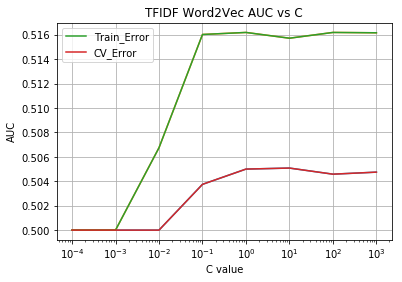

In [216]:
# plot misclassification error vs C 
plot_train_cv_error(returned_pram,returned_pram_train,'TFIDF Word2Vec AUC vs C',C)
plt.show()

**Observation**
We can see that when C value is low, then our model is underfitting, means low AUC on train and low AUC on unseen data. As C increasing AUC on Unseen data increasing till best hyperparamter c=1 after that model started overfitting so AUC on Test data started decreasing, while AUC of training data keep increasing. Hence our best C is 1. 

In [224]:
from sklearn.linear_model import LogisticRegression
best_C=1
LGR = LogisticRegression(C=best_C, penalty='l1')
LGR.fit(train_data, train_traget)
# Prediction on Test data
pred = LGR.predict(test_data)
acc = accuracy_score(test_target, pred, normalize=True) * float(100)
auc=roc_auc_score(test_target, pred)
print(" Alpha C: ",best_C," AUC: ",auc," Acc: ",acc)

 Alpha C:  1  AUC:  0.5125833333333334  Acc:  51.258333333333326


In [225]:
y_true_train = train_traget
y_probas_train = LGR.predict_proba(train_data)
y_true_test = test_target
y_probas_test = LGR.predict_proba(test_data)

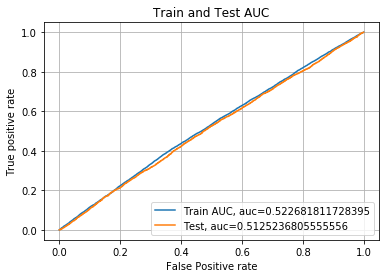

In [226]:
plot_train_test_ROC(y_true_train,LGR,y_true_test,train_data,test_data)
plt.show()

**Observation**

We can see that the Train and Test ROC plot is almost overlapping on best hyperparamter C =1. And the diff of train and Test AUC is not significant than random model so we can say existing features are not working hence model is underfitting. If we need better performance than this we may need to add some new useful features

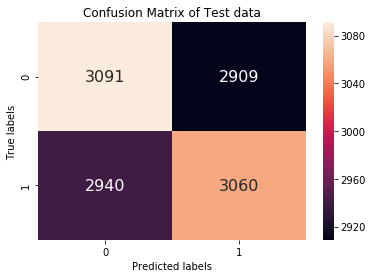

In [227]:
# Confusion matrix
plotconfusionMatrix(y_true_test,LGR,test_data)

**Observation**

We can see that on unseen data(Test set) our diagonal elements have almost similar number than off diagonal with very high no of FP and FN, ie. model is underfitting.If we need better performance than this, i.e to reduce further FP and FN and increase TP and TN then we may need to add some new features.

### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [228]:
# Please write all the code with proper documentation
# Compute train AUC also

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
#Simple Cross Validation
C=[0.0001,0.001,0.01,0.1,1,10,100,1000,]
returned_pram=dict()
returned_pram_train=dict()
for i in tqdm(C):
    # instantiate learning model
    LGR = LogisticRegression(C=i, penalty='l2',n_jobs=-1)

    # fitting the model on crossvalidation train
    LGR.fit(train_data, train_traget)

    # predict the response on the crossvalidation train
    pred_cv = LGR.predict(cv_data)

    # evaluate CV accuracy
    acc_cv = accuracy_score(cv_target, pred_cv, normalize=True) * float(100)
    auc_cv=roc_auc_score(cv_target, pred_cv)
    auc_train=roc_auc_score(train_traget, LGR.predict(train_data))
    print(" C value: ",i," AUC: ",auc_cv," Acc: ",acc_cv," auc_train ",auc_train)
    returned_pram.update({i:auc_cv})
    returned_pram_train.update({i:auc_train})
    gc.collect()


  0%|                                                                                            | 0/8 [00:00<?, ?it/s]C:\Users\Sanjay\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


 C value:  0.0001  AUC:  0.5049166666666666  Acc:  50.49166666666667  auc_train  0.5118333333333334


 12%|██████████▌                                                                         | 1/8 [00:00<00:03,  2.21it/s]C:\Users\Sanjay\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


 C value:  0.001  AUC:  0.5075833333333333  Acc:  50.75833333333334  auc_train  0.5145000000000001


 25%|█████████████████████                                                               | 2/8 [00:00<00:02,  2.16it/s]C:\Users\Sanjay\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


 C value:  0.01  AUC:  0.5063333333333333  Acc:  50.63333333333333  auc_train  0.5168055555555555


 38%|███████████████████████████████▌                                                    | 3/8 [00:01<00:02,  1.97it/s]C:\Users\Sanjay\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


 C value:  0.1  AUC:  0.5058333333333334  Acc:  50.583333333333336  auc_train  0.5162222222222222


 50%|██████████████████████████████████████████                                          | 4/8 [00:02<00:02,  1.85it/s]C:\Users\Sanjay\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


 C value:  1  AUC:  0.50475  Acc:  50.475  auc_train  0.5160833333333333


 62%|████████████████████████████████████████████████████▌                               | 5/8 [00:02<00:01,  1.75it/s]C:\Users\Sanjay\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


 C value:  10  AUC:  0.5048333333333334  Acc:  50.483333333333334  auc_train  0.5161666666666667


 75%|███████████████████████████████████████████████████████████████                     | 6/8 [00:03<00:01,  1.76it/s]C:\Users\Sanjay\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


 C value:  100  AUC:  0.5047499999999999  Acc:  50.475  auc_train  0.5162222222222222


 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [00:04<00:00,  1.60it/s]C:\Users\Sanjay\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


 C value:  1000  AUC:  0.5047499999999999  Acc:  50.475  auc_train  0.51625


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.45it/s]


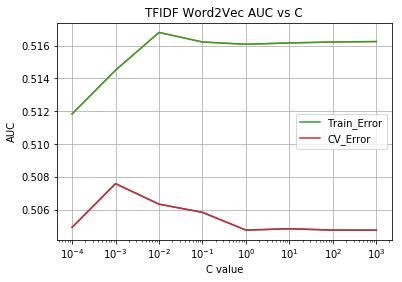

In [229]:
# plot misclassification error vs C 
plot_train_cv_error(returned_pram,returned_pram_train,'TFIDF Word2Vec AUC vs C',C)
plt.show()

**Observation**
We can see that when C value is low, then our model is underfitting, means low AUC on train and low AUC on unseen data. As C increasing AUC on Unseen data increasing till best hyperparamter c=0.001 after that model started overfitting so AUC on Test data started decreasing, while AUC of training data keep increasing. Hence our best C is 0.001. 

In [230]:
from sklearn.linear_model import LogisticRegression
best_C=0.001
LGR = LogisticRegression(C=best_C, penalty='l2')
LGR.fit(train_data, train_traget)
# Prediction on Test data
pred = LGR.predict(test_data)
acc = accuracy_score(test_target, pred, normalize=True) * float(100)
auc=roc_auc_score(test_target, pred)
print(" Alpha C: ",best_C," AUC: ",auc," Acc: ",acc)

 Alpha C:  0.001  AUC:  0.5105  Acc:  51.05


In [231]:
y_true_train = train_traget
y_probas_train = LGR.predict_proba(train_data)
y_true_test = test_target
y_probas_test = LGR.predict_proba(test_data)

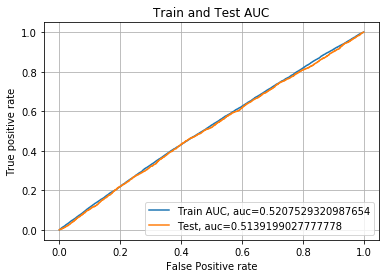

In [232]:
plot_train_test_ROC(y_true_train,LGR,y_true_test,train_data,test_data)
plt.show()


**Observation**

We can see that the Train and Test ROC plot is almost overlapping on best hyperparamter C =0.001. And the diff of train and Test AUC is not significant than random model so we can say existing features are not working hence model is underfitting. If we need better performance than this we may need to add some new useful features

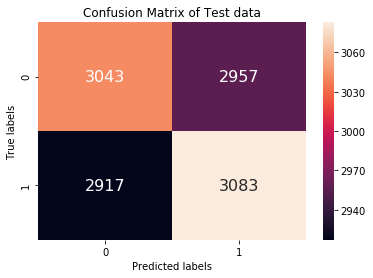

In [233]:
# Confusion matrix
plotconfusionMatrix(y_true_test,LGR,test_data)

**Observation**

We can see that on unseen data(Test set) our diagonal elements have almost similar number than off diagonal with very high no of FP and FN, ie. model is underfitting.If we need better performance than this, i.e to reduce further FP and FN and increase TP and TN then we may need to add some new features.

# [6] Conclusions

In [248]:
# Please compare all your models using Prettytable library
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Best C", "AUC"]

x.add_row(["BOW", "l1_logistic", 0.1, 0.88])
x.add_row(["BOW", "l2_logistic", 0.1, 0.87])
x.add_row(["TFIDF", "l1_logistic", 1, 0.84])
x.add_row(["TFIDF", "l2_logistic", 1, 0.85])
x.add_row(["AvgWord2Vec", "l1_logistic", 0.01, 0.51])
x.add_row(["AvgWord2Vec", "l2_logistic", 0.001, 0.51])
x.add_row(["TFIDFWord2Vec", "l1_logistic", 0.1, 0.51])
x.add_row(["TFIDFWord2Vec", "l2_logistic", 0.001, 0.51])
print(x)


+---------------+-------------+--------+------+
|   Vectorizer  |    Model    | Best C | AUC  |
+---------------+-------------+--------+------+
|      BOW      | l1_logistic |  0.1   | 0.88 |
|      BOW      | l2_logistic |  0.1   | 0.87 |
|     TFIDF     | l1_logistic |   1    | 0.84 |
|     TFIDF     | l2_logistic |   1    | 0.85 |
|  AvgWord2Vec  | l1_logistic |  0.01  | 0.51 |
|  AvgWord2Vec  | l2_logistic | 0.001  | 0.51 |
| TFIDFWord2Vec | l1_logistic |  0.1   | 0.51 |
| TFIDFWord2Vec | l2_logistic | 0.001  | 0.51 |
+---------------+-------------+--------+------+


**Observation**

We can see that with all 8 type of models BOW vectorizer with l1 regularizer performing better with maximum AUC 88%.TFIDF based vectorizer gave 2nd best solution with aprrox same AUC on both l1 and l2. On the other word2vec vectorizer on both avg and TFIDF performing worst and similar to random model. 